
-- Decision Tree vs Random Forest results (classification) --
                            acc      prec       rec        f1  train_time_s
DecisionTree_unscaled  0.744412  0.742999  0.744412  0.743537      0.129778
DecisionTree_scaled    0.744412  0.742945  0.744412  0.743515      0.127288
RandomForest_100       0.794118  0.793800  0.794118  0.793837      1.067413
RF_n_1                 0.672941  0.671591  0.672941  0.672192      0.036609
RF_n_5                 0.740000  0.739634  0.740000  0.738619      0.081411
RF_n_10                0.766176  0.765702  0.766176  0.765268      0.134435
RF_n_25                0.784706  0.784648  0.784706  0.784280      0.299443
RF_n_50                0.791765  0.791510  0.791765  0.791268      0.549448
RF_n_100               0.794118  0.793800  0.794118  0.793837      1.088006
RF_n_200               0.795000  0.794732  0.795000  0.794722      2.158638

Simple ensembles (hard, soft, weighted) accuracies:
{'hard_acc': 0.7667647058823529, 'soft_acc': 0.7

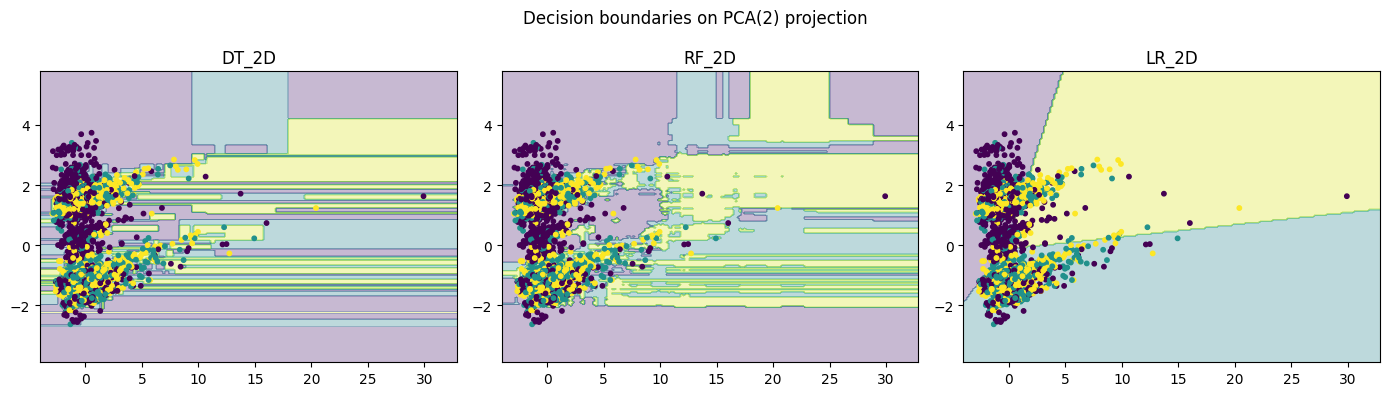


Feature importances (RF clf & reg):
              feature   imp_clf   imp_reg
7       median_income  0.270157  0.519755
0           longitude  0.180156  0.158070
1            latitude  0.173131  0.144866
2  housing_median_age  0.069527  0.067403
5          population  0.085379  0.036366
4      total_bedrooms  0.069584  0.027190
3         total_rooms  0.082267  0.025289
6          households  0.069799  0.021059

Homogeneous vs Heterogeneous:
              Homogeneous_RF  Heterogeneous_Voting
acc                 0.794118              0.773235
prec                0.793800              0.771348
rec                 0.794118              0.773235
f1                  0.793837              0.772066
train_time_s        2.732164              0.620113

Script finished. Inspect printed tables & figures for results. Save outputs as needed.


In [1]:
import time, warnings, sys
warnings.filterwarnings("ignore")
import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, VotingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.stats import mode

# PATH: change this if your file is elsewhere
DATA_PATH = "/kaggle/input/californian-housing/california_housing_train.csv"

# --- load dataset
try:
    df = pd.read_csv(DATA_PATH)
except FileNotFoundError:
    raise SystemExit(f"DATA FILE NOT FOUND. Put 'california_housing_train.csv' in working dir or change DATA_PATH. (Tried: {DATA_PATH})")

# basic cleaning
df = df.dropna().reset_index(drop=True)

# create classification target (3 classes by quantiles)
df['price_cat'] = pd.qcut(df['median_house_value'], q=3, labels=['low','medium','high'])
df['price_cat_code'] = df['price_cat'].map({'low':0,'medium':1,'high':2})

# features and targets
X = df.drop(['median_house_value','price_cat','price_cat_code'], axis=1)
y_reg = df['median_house_value']
y_clf = df['price_cat_code']

# train/test split (stratify for classification)
X_train, X_test, y_train_clf, y_test_clf, y_train_reg, y_test_reg = train_test_split(
    X, y_clf, y_reg, test_size=0.20, random_state=42, stratify=y_clf)

# scale for models that benefit
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# helper evaluation for classifiers
def eval_clf(model, Xtr, Xte, ytr, yte):
    t0 = time.time()
    model.fit(Xtr, ytr)
    t1 = time.time()
    preds = model.predict(Xte)
    acc = accuracy_score(yte, preds)
    prec = precision_score(yte, preds, average='weighted', zero_division=0)
    rec = recall_score(yte, preds, average='weighted', zero_division=0)
    f1 = f1_score(yte, preds, average='weighted', zero_division=0)
    return {"acc":acc, "prec":prec, "rec":rec, "f1":f1, "train_time_s":(t1-t0)}

# ----------------------
# 1. Decision Tree vs Random Forest (classification) + n_estimators sweep
# ----------------------
dt = DecisionTreeClassifier(random_state=42)
rf_default = RandomForestClassifier(random_state=42, n_jobs=-1)

res = {}
res['DecisionTree_unscaled'] = eval_clf(dt, X_train, X_test, y_train_clf, y_test_clf)
res['DecisionTree_scaled'] = eval_clf(dt, X_train_s, X_test_s, y_train_clf, y_test_clf)
res['RandomForest_100'] = eval_clf(rf_default, X_train, X_test, y_train_clf, y_test_clf)

for n in [1,5,10,25,50,100,200]:
    rf = RandomForestClassifier(n_estimators=n, random_state=42, n_jobs=-1)
    res[f"RF_n_{n}"] = eval_clf(rf, X_train, X_test, y_train_clf, y_test_clf)

print("\n-- Decision Tree vs Random Forest results (classification) --")
print(pd.DataFrame(res).T)

# ----------------------
# 2. Simple ensemble techniques (max voting, average voting, weighted average)
# ----------------------
clf1 = DecisionTreeClassifier(random_state=1)
clf2 = LogisticRegression(max_iter=1000, random_state=1)
clf3 = KNeighborsClassifier(n_neighbors=5)

clf1.fit(X_train_s, y_train_clf); clf2.fit(X_train_s, y_train_clf); clf3.fit(X_train_s, y_train_clf)
p1 = clf1.predict(X_test_s); p2 = clf2.predict(X_test_s); p3 = clf3.predict(X_test_s)
hard_vote = mode(np.vstack([p1,p2,p3]), axis=0).mode.flatten()
hard_acc = accuracy_score(y_test_clf, hard_vote)

# soft (average probabilities)
prob1 = clf1.predict_proba(X_test_s)
prob2 = clf2.predict_proba(X_test_s)
prob3 = clf3.predict_proba(X_test_s)
avg_prob = (prob1 + prob2 + prob3) / 3.0
soft_preds = np.argmax(avg_prob, axis=1)
soft_acc = accuracy_score(y_test_clf, soft_preds)

# weighted soft: weights from cv scores on training set
w1 = cross_val_score(clf1, X_train_s, y_train_clf, cv=3).mean()
w2 = cross_val_score(clf2, X_train_s, y_train_clf, cv=3).mean()
w3 = cross_val_score(clf3, X_train_s, y_train_clf, cv=3).mean()
weights = np.array([w1,w2,w3])
wprob = (prob1*w1 + prob2*w2 + prob3*w3) / weights.sum()
w_preds = np.argmax(wprob, axis=1)
w_acc = accuracy_score(y_test_clf, w_preds)

print("\nSimple ensembles (hard, soft, weighted) accuracies:")
print({"hard_acc":hard_acc, "soft_acc":soft_acc, "weighted_acc":w_acc, "weights":[w1,w2,w3]})

# ----------------------
# 3. Hard voting vs Soft voting (VotingClassifier)
# ----------------------
vc_hard = VotingClassifier(estimators=[('dt', clf1), ('lr', clf2), ('knn', clf3)], voting='hard')
vc_soft = VotingClassifier(estimators=[('dt', clf1), ('lr', clf2), ('knn', clf3)], voting='soft')
res_v = {}
res_v['voting_hard'] = eval_clf(vc_hard, X_train_s, X_test_s, y_train_clf, y_test_clf)
res_v['voting_soft'] = eval_clf(vc_soft, X_train_s, X_test_s, y_train_clf, y_test_clf)
print("\nVotingClassifier (hard vs soft):")
print(pd.DataFrame(res_v).T)

# ----------------------
# 4. Bagging / RandomForest param experiments (classification)
# ----------------------
rf_sweep = {}
for maxd in [None, 5, 10, 20]:
    for n in [10,50,100,200]:
        rf = RandomForestClassifier(n_estimators=n, max_depth=maxd, random_state=42, n_jobs=-1)
        rf_sweep[f"RF_n{n}_maxd{maxd}"] = eval_clf(rf, X_train, X_test, y_train_clf, y_test_clf)
print("\nRandomForest parameter sweep summary (sample):")
print(pd.DataFrame(rf_sweep).T.head(8))

# ----------------------
# 5. RandomForestRegressor with OOB score
# ----------------------
rfr = RandomForestRegressor(n_estimators=100, oob_score=True, random_state=42, n_jobs=-1)
rfr.fit(X_train, y_train_reg)
oob = getattr(rfr, "oob_score_", None)
y_pred_rfr = rfr.predict(X_test)
r2 = r2_score(y_test_reg, y_pred_rfr)
mse = mean_squared_error(y_test_reg, y_pred_rfr)
print(f"\nRandomForestRegressor: OOB_score={oob:.4f}, test R2={r2:.4f}, test MSE={mse:.2f}")

oob_results = []
for n in [10,25,50,100,200]:
    m = RandomForestRegressor(n_estimators=n, oob_score=True, random_state=42, n_jobs=-1)
    m.fit(X_train, y_train_reg)
    o = getattr(m, "oob_score_", np.nan)
    r2t = r2_score(y_test_reg, m.predict(X_test))
    oob_results.append({"n_estimators":n, "oob_score":o, "test_R2":r2t})
print("\nOOB vs test R2 for different n_estimators (RFR):")
print(pd.DataFrame(oob_results))

# ----------------------
# 6. Boosting (AdaBoost, GradientBoosting, XGBoost, CatBoost if available)
# ----------------------
boosting_res = {}
adb = AdaBoostClassifier(n_estimators=50, random_state=42)
boosting_res['AdaBoost'] = eval_clf(adb, X_train_s, X_test_s, y_train_clf, y_test_clf)

gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
boosting_res['GradBoost'] = eval_clf(gb, X_train_s, X_test_s, y_train_clf, y_test_clf)

# try XGBoost
try:
    import xgboost as xgb
    xgbc = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42, n_jobs=-1)
    boosting_res['XGBoost'] = eval_clf(xgbc, X_train_s, X_test_s, y_train_clf, y_test_clf)
    print("XGBoost available and tested.")
except Exception as e:
    print("XGBoost not available in this environment; skipped XGBoost.")

# try CatBoost
try:
    from catboost import CatBoostClassifier
    cat = CatBoostClassifier(verbose=0, random_state=42)
    boosting_res['CatBoost'] = eval_clf(cat, X_train_s, X_test_s, y_train_clf, y_test_clf)
    print("CatBoost available and tested.")
except Exception as e:
    print("CatBoost not available in this environment; skipped CatBoost.")

print("\nBoosting results (classification):")
print(pd.DataFrame(boosting_res).T)

# ----------------------
# 7. Comparative study (pick a group of models & measure train time + metrics)
# ----------------------
comparisons = {}
models_for_compare = {
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RandomForest100": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "AdaBoost50": AdaBoostClassifier(n_estimators=50, random_state=42),
    "GradBoost100": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "VotingSoft": VotingClassifier(estimators=[('dt', DecisionTreeClassifier()),('lr', LogisticRegression(max_iter=1000)),('knn', KNeighborsClassifier())], voting='soft')
}
# append xgboost/catboost if available
if 'xgbc' in globals():
    models_for_compare['XGBoost'] = xgbc
if 'cat' in globals():
    models_for_compare['CatBoost'] = cat

for name, m in models_for_compare.items():
    t0 = time.time()
    m.fit(X_train_s, y_train_clf)
    t1 = time.time()
    preds = m.predict(X_test_s)
    comparisons[name] = {
        "accuracy": accuracy_score(y_test_clf, preds),
        "f1_weighted": f1_score(y_test_clf, preds, average='weighted'),
        "train_time_s": t1 - t0
    }
print("\nComparative table (selected models):")
print(pd.DataFrame(comparisons).T.sort_values("accuracy", ascending=False))

# ----------------------
# 8. Visualizations: PCA decision boundaries & feature importances
# ----------------------
pca = PCA(n_components=2, random_state=42)
Xtr2 = pca.fit_transform(X_train_s)
Xte2 = pca.transform(X_test_s)

vis_clfs = [
    ("DT_2D", DecisionTreeClassifier(random_state=42)),
    ("RF_2D", RandomForestClassifier(n_estimators=100, random_state=42)),
    ("LR_2D", LogisticRegression(max_iter=1000))
]
fig, axes = plt.subplots(1, len(vis_clfs), figsize=(14,4))
xx_min, xx_max = Xtr2[:,0].min()-1, Xtr2[:,0].max()+1
yy_min, yy_max = Xtr2[:,1].min()-1, Xtr2[:,1].max()+1
xx, yy = np.meshgrid(np.linspace(xx_min, xx_max, 200), np.linspace(yy_min, yy_max, 200))

for ax, (name, clf) in zip(axes, vis_clfs):
    clf.fit(Xtr2, y_train_clf)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.3)
    sc = ax.scatter(Xte2[:,0], Xte2[:,1], c=y_test_clf, s=10)
    ax.set_title(name)
plt.suptitle("Decision boundaries on PCA(2) projection")
plt.tight_layout(); plt.show()

# feature importances (RF classifier & regressor)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train_clf)
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train_reg)
feat_imp = pd.DataFrame({"feature": X.columns, "imp_clf": rf_clf.feature_importances_, "imp_reg": rf_reg.feature_importances_})
print("\nFeature importances (RF clf & reg):")
print(feat_imp.sort_values("imp_reg", ascending=False))

# ----------------------
# 9. Heterogeneous ensemble: VotingClassifier with diverse learners vs homogeneous RF
# ----------------------
hom = RandomForestClassifier(n_estimators=100, random_state=42)
het = VotingClassifier(estimators=[('dt', DecisionTreeClassifier()), ('lr', LogisticRegression(max_iter=1000)), ('knn', KNeighborsClassifier())], voting='soft')

hom_res = eval_clf(hom, X_train, X_test, y_train_clf, y_test_clf)
het_res = eval_clf(het, X_train_s, X_test_s, y_train_clf, y_test_clf)
print("\nHomogeneous vs Heterogeneous:")
print(pd.DataFrame({"Homogeneous_RF":hom_res, "Heterogeneous_Voting":het_res}))

# ----------------------
# 10. Homogeneous vs Heterogeneous summary is above (use the printed tables)
# ----------------------
print("\nScript finished. Inspect printed tables & figures for results. Save outputs as needed.")